**PLAYING WITH THE TENSORFLOW API**

***

***

# Packages

In [1]:
# Essential libraries.
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Modules.
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# Disable GPU.
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

# Information.
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Num GPUs Available:  1


2022-09-13 15:23:02.881049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 15:23:02.885635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 15:23:02.885757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

***

***

# Dataset

## Split into training and validation sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap.

Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

In [3]:
batch_size = 32
img_size = (224, 224)
directory = 'Sentinel2GlobalLULC/Sentinel2LULC_JPEG/'

split_train_val = 0.2
shuffle = True

# Train set.
train_dataset = image_dataset_from_directory(directory,
                                             label_mode='categorical',
                                             batch_size=batch_size,
                                             image_size=img_size,
                                             shuffle=shuffle,
                                             seed=42,
                                             validation_split=split_train_val,
                                             subset='training')

# Validation set.
validation_dataset = image_dataset_from_directory(directory,
                                                  label_mode='categorical',
                                                  batch_size=batch_size,
                                                  image_size=img_size,
                                                  shuffle=shuffle,
                                                  seed=42,
                                                  validation_split=split_train_val,
                                                  subset='validation')

# Test set extracted from the validation one.
split_val_test = 0.2
n_test_samples = int(split_val_test * len(validation_dataset))
test_dataset = validation_dataset.take(n_test_samples)
validation_dataset = validation_dataset.skip(n_test_samples)

# Show stats.
print('Training samples: ' + str(len(train_dataset) * batch_size))
print('Validation samples: ' + str(len(validation_dataset) * batch_size))
print('Test samples: ' + str(len(test_dataset) * batch_size))
print('Total approx.: ' + str((len(train_dataset) + len(validation_dataset) + len(test_dataset)) * batch_size))

Found 194877 files belonging to 29 classes.
Using 155902 files for training.


2022-09-13 15:23:09.275743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 15:23:09.276249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 15:23:09.276455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 15:23:09.276559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Found 194877 files belonging to 29 classes.
Using 38975 files for validation.
Training samples: 155904
Validation samples: 31200
Test samples: 7776
Total approx.: 194880


## Show some examples from the training set

Classes:  ['01_BarrenLands___jpeg', '02_MossAndLichen_jpeg', '03_Grasslands____jpeg', '04_ShrublandOpen_jpeg', '05_SrublandClose_jpeg', '06_ForestsOpDeBr_jpeg', '07_ForestsClDeBr_jpeg', '08_ForestsDeDeBr_jpeg', '09_ForestsOpDeNe_jpeg', '10_ForestsClDeNe_jpeg', '11_ForestsDeDeNe_jpeg', '12_ForestsOpEvBr_jpeg', '13_ForestsClEvBr_jpeg', '14_ForestsDeEvBr_jpeg', '15_ForestsOpEvNe_jpeg', '16_ForestsClEvNe_jpeg', '17_ForestsDeEvNe_jpeg', '18_WetlandMangro_jpeg', '19_WetlandSwamps_jpeg', '20_WetlandMarshl_jpeg', '21_WaterBodyMari_jpeg', '22_WaterBodyCont_jpeg', '23_PermanentSnow_jpeg', '24_CropSeasWater_jpeg', '25_CropCereaIrri_jpeg', '26_CropCereaRain_jpeg', '27_CropBroadIrri_jpeg', '28_CropBroadRain_jpeg', '29_UrbanBlUpArea_jpeg']
Number of classes:  29


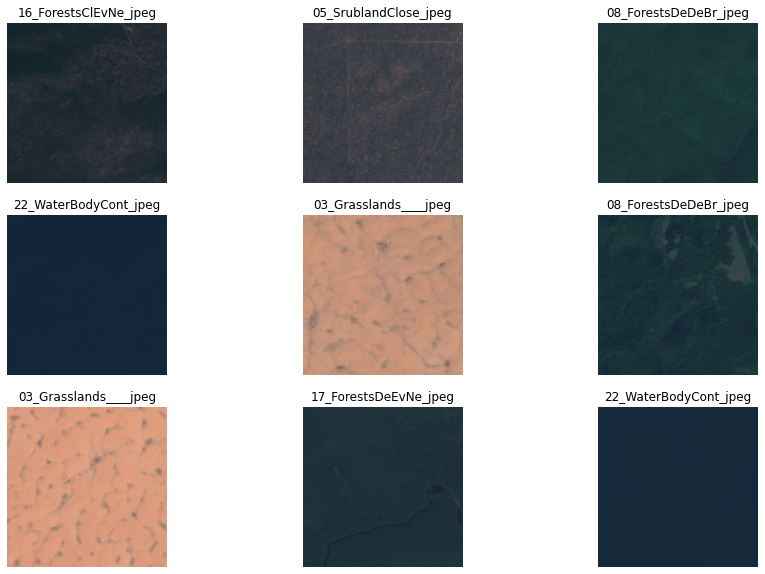

In [4]:
# Dealing with the different classes.
class_names = train_dataset.class_names
n_classes = len(class_names)

# Show more stats.
print('Classes: ', class_names)
print('Number of classes: ', n_classes)

# Example.
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):    # Take a batch.
    for i in range(9):                          # Take nine images.
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])    # no one-hot
        plt.title(class_names[np.argmax(labels[i])])    # one-hot
        plt.axis("off")

***

***

# Preprocesses

## Prefetch()

You may have encountered `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

In [5]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=autotune)

## Augmenting training data

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [15]:
def data_augmenter():
    """
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    """
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal_and_vertical'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

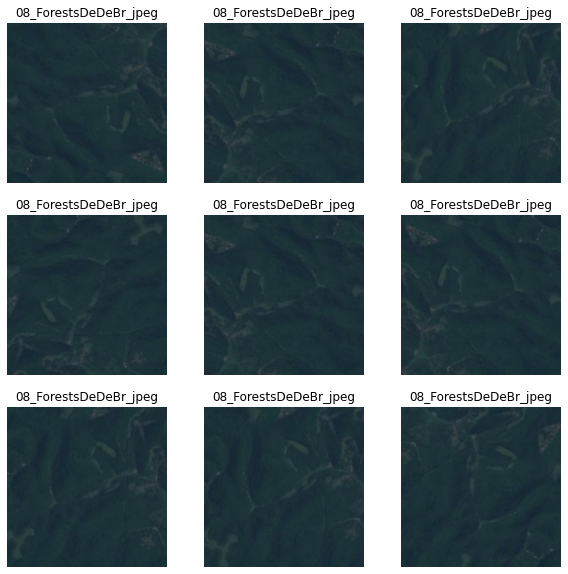

In [7]:
data_augmentation = data_augmenter()

for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image, first_label = image[0], label[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[np.argmax(first_label)])
        plt.axis('off')

***

***

# Training the model

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

## Model definition (transfer learning and DATA AUGMENTATION)

In [9]:
def get_model():

    # Set 3D input shape.
    input_shape = img_size + (3,)

    # Loading the pre-trained model without the top layers.
    base_model = VGG16(include_top=False,
                       weights='imagenet',
                       input_shape=input_shape)

    # Freeze the base model.
    base_model.trainable = False

    # Create the input layer.
    inputs = tf.keras.Input(shape=input_shape) 

    # Apply data augmentation to the inputs. HERE
    x = data_augmentation(inputs, training=True)

    # Data preprocessing using the same weights the model was trained on.
    x = preprocess_input(x)

    # Set training to False to avoid keeping track of statistics in the batch norm layer.
    x = base_model(x, training=False)

    # Add the new Binary classification layers.
    # Use global avg pooling to summarize the info in each channel.
    x = tfl.GlobalAveragePooling2D()(x)

    # Include dropout to avoid overfitting.
    x = tfl.Dropout(0.2)(x)

    # Output layer.
    x = tfl.Flatten()(x)
    outputs = tfl.Dense(n_classes, activation='softmax')(x)

    # Create model.
    model = tf.keras.Model(inputs, outputs)
    
    return model

## Callbacks

### Print val-train ration

In [10]:
# Custom callback: New print during fit.
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("val/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

val_train_ratio_cb = PrintValTrainRatioCallback()

### Model checkpoint

In [11]:
# Checkpoint callback: epoch in the file name.
checkpoint_path = 'model-{epoch:02d}-{val_loss:.4f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Checkpoint callback: definition.
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

### TensorBoard logs

In [12]:
# TensorBoard logs callback.
def get_run_logdir(root_logdir):
    import time
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

root_logdir = os.path.join(os.curdir, 'my_logs')

run_logdir = get_run_logdir(root_logdir) # e.g., './my_logs/run_2019_06_07-15_15_22'
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

## Model

In [13]:
# Create a new model instance.
model = get_model()

# Compile.
base_learning_rate = 0.01    # 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Train the model with the new callback.
initial_epochs = 5
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[val_train_ratio_cb,
                               cp_callback,
                               tensorboard_cb])

Epoch 1/5


2022-09-13 15:23:18.410205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


   2/4872 [..............................] - ETA: 7:20 - loss: 4.6398 - categorical_accuracy: 0.0312       

2022-09-13 15:23:21.048642: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4872/4872 [==============================] - ETA: 0s - loss: 0.8292 - categorical_accuracy: 0.7799val/train: 0.74

Epoch 1: saving model to model-01-0.6143.h5
4872/4872 [==============================] - 590s 120ms/step - loss: 0.8292 - categorical_accuracy: 0.7799 - val_loss: 0.6143 - val_categorical_accuracy: 0.8394
Epoch 2/5
4872/4872 [==============================] - ETA: 0s - loss: 0.8264 - categorical_accuracy: 0.8024val/train: 0.78

Epoch 2: saving model to model-02-0.6445.h5
4872/4872 [==============================] - 578s 119ms/step - loss: 0.8264 - categorical_accuracy: 0.8024 - val_loss: 0.6445 - val_categorical_accuracy: 0.8349
Epoch 3/5
4872/4872 [==============================] - ETA: 0s - loss: 0.8396 - categorical_accuracy: 0.8051val/train: 0.76

Epoch 3: saving model to model-03-0.6398.h5
4872/4872 [==============================] - 569s 117ms/step - loss: 0.8396 - categorical_accuracy: 0.8051 - val_loss: 0.6398 - val_categorical_accuracy: 0.8318
Epoch 4/5
4872/4872 

## TensorBoard

In [14]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

***

***

# Evaluation

In [12]:
# Evaluate current model
model.evaluate(validation_dataset)

975/975 [==============================] - 89s 90ms/step - loss: 0.3360 - categorical_accuracy: 0.8885


[0.3360423147678375, 0.8885220885276794]

In [13]:
# Review the resulting checkpoints and choose the latest one.
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a new model instance
new_model = create_model()

# Load the previously saved weights
new_model.load_weights(latest)

# Re-evaluate the model
new_model.evaluate(validation_dataset)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

***

***

***

***

## Save the whole model

Keras also supports saving a single HDF5 file containing the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel.

In [ ]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("my_model")

# Model summary.
model.summary()

In [ ]:
# It can be used to reconstruct the model identically.
new_model = tf.keras.models.load_model("my_model")

# Reconstructed model summary.
new_model.summary()

In [ ]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = new_model.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save only the weights

In [ ]:
# Save only weights.
model.save_weights("weights.h5")

In [ ]:
# Load only weights.
reconstructed_model = get_model()
reconstructed_model.load_weights("weights.h5")

# Reconstructed model summary.
reconstructed_model.summary()

In [ ]:
# Check that all of the pretrained weights have been loaded.
for a, b in zip(model.weights, reconstructed_model.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())

In [ ]:
# Let's check:
# np.testing.assert_allclose(
#     model.predict(validation_dataset), reconstructed_model.predict(validation_dataset)
# )

In [ ]:
model.evaluate(validation_dataset)
reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                            loss=tf.keras.losses.categorical_crossentropy,
                            metrics=['accuracy'])
reconstructed_model.evaluate(validation_dataset)

***

***

# Test time

In [ ]:
for images, labels in validation_dataset.take(1):    # only take first element of dataset, batch in this case as it is prefetched
    
    # Batch id.
    idx = 2
    numpy_batch_images = images.numpy()
    numpy_batch_labels = labels.numpy()
    
    # Plot target img.
    plt.imshow(numpy_batch_images[idx].astype("uint8"))
    print(class_names[np.argmax(numpy_batch_labels[idx])])
    
    # Prediction.
    predictions = model.predict(numpy_batch_images)[idx]
    print('\n', predictions)
    print(class_names[np.argmax(predictions)], predictions[np.argmax(predictions)])


# Fine-tuning the model by unfreezing more layers

In [ ]:
base_model = new_model.layers[3]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

base_model.summary()

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

history_fine2 = new_model.fit(train_dataset,
                              epochs=5,
                              initial_epoch=history.epoch[-1],
                              validation_data=validation_dataset)

initial_epochs = total_epochs
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])

In [ ]:
acc += history_fine2.history['accuracy']
val_acc += history_fine2.history['val_accuracy']

loss += history_fine2.history['loss']
val_loss += history_fine2.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()